In [38]:
import cv2

In [ ]:
# ==============================
# FEATURE EXTRACTION EXPERIMENT
# ==============================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import cv2
import pickle
import os
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torchvision.models import ResNet18_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

base_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

normalize = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

normalized_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

augment_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# Dataset dictionary
transform_variations = {
    "Base": base_transform,
    "Normalized": normalized_transform,
    "Normalized + Augment": augment_transform,
    "Normalized + Augment + Regularize": augment_transform  # regularization in model, not transform
}


def train_feature_extraction(model, train_loader, val_loader, epochs=10, lr=1e-3, regularize=False, history=None):
    # Freeze all layers except final classifier
    for param in model.parameters():
        param.requires_grad = False
    # for param in model.layer4.parameters():
    #     param.requires_grad = True
    for param in model.fc.parameters():
        param.requires_grad = True

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(model.layer4.parameters()) + list(model.fc.parameters()), lr=lr, weight_decay=1e-3 if regularize else 0.0)
    # Create history if not provided
    if history is None:
        history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute training accuracy
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        model.eval()
        val_loss_total = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_total += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = val_loss_total / len(val_loader)
        val_acc = 100 * correct_val / total_val

        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"- Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} "
              f"| Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    return history


In [40]:
print(device)

cuda


In [ ]:
# ---------------------------
# GRAD-CAM IMPLEMENTATION
# ---------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach().clone()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach().clone()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, target_class=None):
        self.model.zero_grad()
        out = self.model(input_tensor)
        if target_class is None:
            target_class = out.argmax(dim=1).item()
        one_hot = torch.zeros_like(out)
        one_hot[0, target_class] = 1
        out.backward(gradient=one_hot, retain_graph=True)

        grads = self.gradients        # BxCxhxw
        acts = self.activations      # BxCxhxw
        weights = grads.mean(dim=(2,3), keepdim=True)  # BxCx1x1
        cam = (weights * acts).sum(dim=1)              # Bxhxw
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam, target_class


In [42]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485]).view(1, 1, 1)
    std = torch.tensor([0.229]).view(1, 1, 1)
    return img_tensor * std + mean

In [43]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"\nAccuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    return acc, prec, rec, f1


🔹 Running Base dataset
Epoch [1/10] - Train Loss: 1.3724, Val Loss: 0.9339 | Train Acc: 58.07%, Val Acc: 70.42%
Epoch [2/10] - Train Loss: 0.8780, Val Loss: 0.8258 | Train Acc: 71.86%, Val Acc: 73.62%
Epoch [3/10] - Train Loss: 0.8026, Val Loss: 0.7683 | Train Acc: 74.21%, Val Acc: 76.00%
Epoch [4/10] - Train Loss: 0.7612, Val Loss: 0.7470 | Train Acc: 75.60%, Val Acc: 76.68%
Epoch [5/10] - Train Loss: 0.7422, Val Loss: 0.7221 | Train Acc: 76.16%, Val Acc: 77.42%
Epoch [6/10] - Train Loss: 0.7241, Val Loss: 0.7163 | Train Acc: 76.87%, Val Acc: 77.38%
Epoch [7/10] - Train Loss: 0.7129, Val Loss: 0.7154 | Train Acc: 77.01%, Val Acc: 77.35%
Epoch [8/10] - Train Loss: 0.7089, Val Loss: 0.7133 | Train Acc: 77.11%, Val Acc: 77.70%
Epoch [9/10] - Train Loss: 0.7057, Val Loss: 0.6987 | Train Acc: 77.39%, Val Acc: 77.83%
Epoch [10/10] - Train Loss: 0.6994, Val Loss: 0.7096 | Train Acc: 77.45%, Val Acc: 77.39%

Accuracy: 0.7801 | Precision: 0.7807 | Recall: 0.7766 | F1: 0.7751


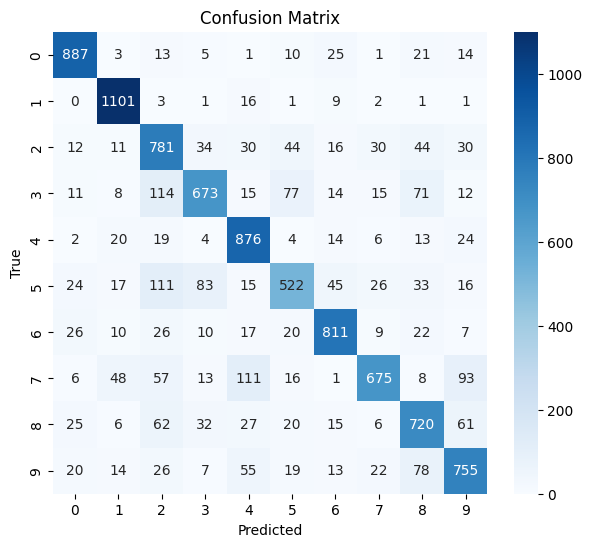

✅ Base Test Accuracy: 0.78%


/tmp/ipykernel_29932/3184266790.py:75: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_dataset.targets) == i)[0][0]


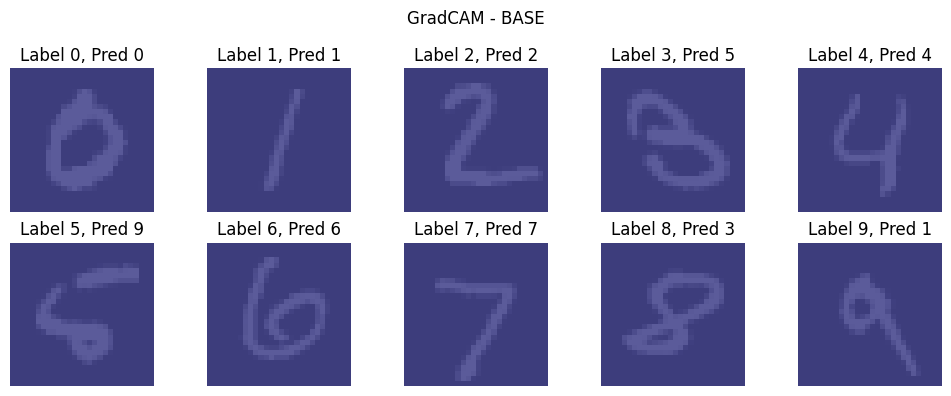


🔹 Running Normalized dataset
Epoch [1/10] - Train Loss: 1.3970, Val Loss: 0.9683 | Train Acc: 56.77%, Val Acc: 69.24%
Epoch [2/10] - Train Loss: 0.9247, Val Loss: 0.8677 | Train Acc: 70.54%, Val Acc: 71.99%
Epoch [3/10] - Train Loss: 0.8613, Val Loss: 0.8327 | Train Acc: 72.18%, Val Acc: 73.17%
Epoch [4/10] - Train Loss: 0.8208, Val Loss: 0.8130 | Train Acc: 73.69%, Val Acc: 74.13%
Epoch [5/10] - Train Loss: 0.7950, Val Loss: 0.7787 | Train Acc: 74.43%, Val Acc: 75.54%
Epoch [6/10] - Train Loss: 0.7770, Val Loss: 0.7681 | Train Acc: 75.05%, Val Acc: 75.58%
Epoch [7/10] - Train Loss: 0.7574, Val Loss: 0.7558 | Train Acc: 75.59%, Val Acc: 75.79%
Epoch [8/10] - Train Loss: 0.7461, Val Loss: 0.7493 | Train Acc: 76.14%, Val Acc: 76.55%
Epoch [9/10] - Train Loss: 0.7384, Val Loss: 0.7655 | Train Acc: 76.14%, Val Acc: 75.37%
Epoch [10/10] - Train Loss: 0.7351, Val Loss: 0.7405 | Train Acc: 76.50%, Val Acc: 76.00%

Accuracy: 0.7666 | Precision: 0.7658 | Recall: 0.7625 | F1: 0.7620


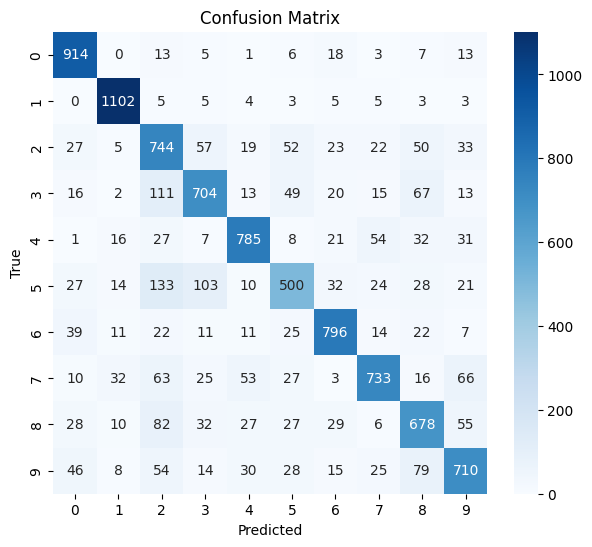

✅ Normalized Test Accuracy: 0.77%


/tmp/ipykernel_29932/3184266790.py:75: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_dataset.targets) == i)[0][0]


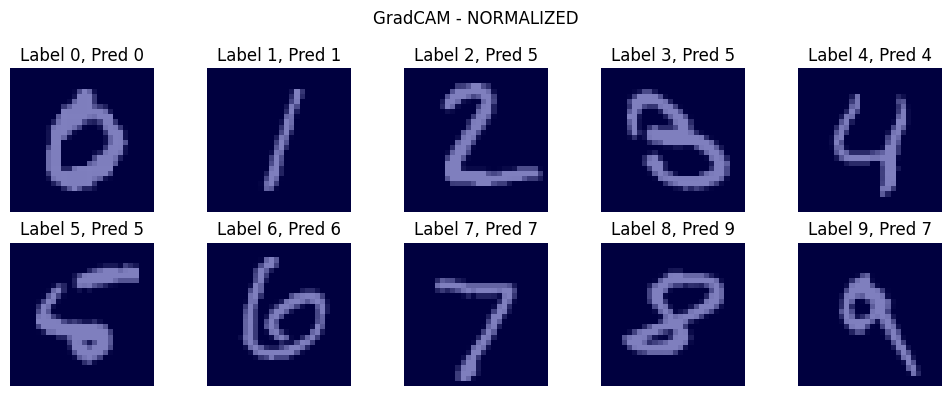


🔹 Running Normalized + Augment dataset
Epoch [1/10] - Train Loss: 1.5758, Val Loss: 1.1927 | Train Acc: 49.27%, Val Acc: 61.12%
Epoch [2/10] - Train Loss: 1.1324, Val Loss: 1.0591 | Train Acc: 62.68%, Val Acc: 65.23%
Epoch [3/10] - Train Loss: 1.0591, Val Loss: 1.0259 | Train Acc: 64.99%, Val Acc: 66.71%
Epoch [4/10] - Train Loss: 1.0175, Val Loss: 0.9821 | Train Acc: 66.56%, Val Acc: 68.07%
Epoch [5/10] - Train Loss: 0.9944, Val Loss: 0.9926 | Train Acc: 67.70%, Val Acc: 67.42%
Epoch [6/10] - Train Loss: 0.9886, Val Loss: 0.9621 | Train Acc: 67.79%, Val Acc: 68.96%
Epoch [7/10] - Train Loss: 0.9743, Val Loss: 0.9616 | Train Acc: 68.19%, Val Acc: 69.39%
Epoch [8/10] - Train Loss: 0.9838, Val Loss: 0.9486 | Train Acc: 67.80%, Val Acc: 69.71%
Epoch [9/10] - Train Loss: 0.9674, Val Loss: 0.9380 | Train Acc: 68.43%, Val Acc: 69.52%
Epoch [10/10] - Train Loss: 0.9646, Val Loss: 0.9420 | Train Acc: 68.51%, Val Acc: 69.38%

Accuracy: 0.6988 | Precision: 0.6998 | Recall: 0.6932 | F1: 0.6919


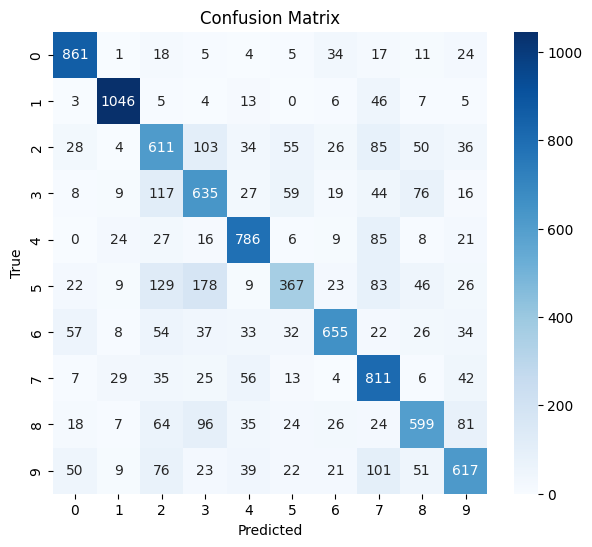

✅ Normalized + Augment Test Accuracy: 0.70%


/tmp/ipykernel_29932/3184266790.py:75: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_dataset.targets) == i)[0][0]


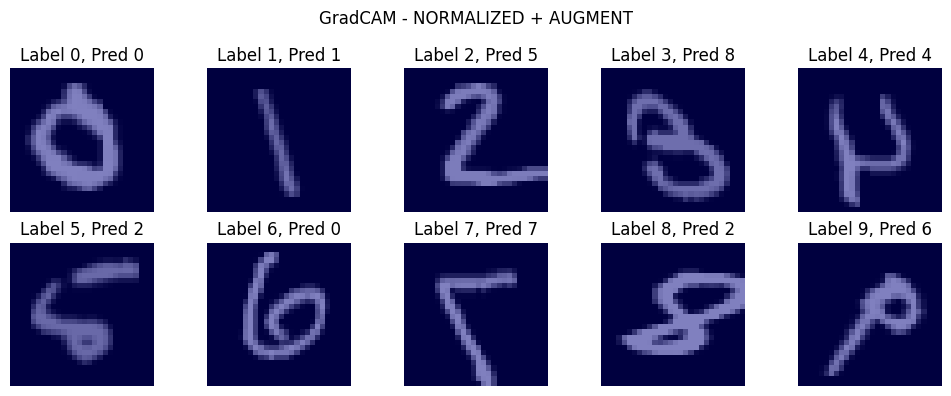


🔹 Running Normalized + Augment + Regularize dataset
Epoch [1/10] - Train Loss: 1.7120, Val Loss: 1.2952 | Train Acc: 42.41%, Val Acc: 58.77%
Epoch [2/10] - Train Loss: 1.2953, Val Loss: 1.1273 | Train Acc: 57.17%, Val Acc: 63.83%
Epoch [3/10] - Train Loss: 1.2103, Val Loss: 1.0587 | Train Acc: 60.09%, Val Acc: 65.74%
Epoch [4/10] - Train Loss: 1.1617, Val Loss: 1.0385 | Train Acc: 62.01%, Val Acc: 66.83%
Epoch [5/10] - Train Loss: 1.1336, Val Loss: 1.0140 | Train Acc: 62.75%, Val Acc: 67.29%
Epoch [6/10] - Train Loss: 1.1235, Val Loss: 1.0017 | Train Acc: 63.62%, Val Acc: 67.83%
Epoch [7/10] - Train Loss: 1.1101, Val Loss: 0.9965 | Train Acc: 63.92%, Val Acc: 68.17%
Epoch [8/10] - Train Loss: 1.1029, Val Loss: 0.9741 | Train Acc: 64.30%, Val Acc: 68.82%
Epoch [9/10] - Train Loss: 1.0929, Val Loss: 0.9785 | Train Acc: 64.45%, Val Acc: 69.24%
Epoch [10/10] - Train Loss: 1.0903, Val Loss: 0.9622 | Train Acc: 64.52%, Val Acc: 69.42%

Accuracy: 0.6930 | Precision: 0.6871 | Recall: 0.6882 |

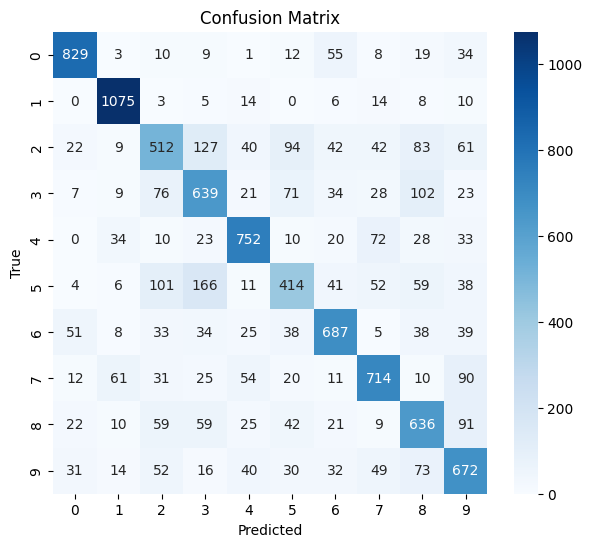

✅ Normalized + Augment + Regularize Test Accuracy: 0.69%


/tmp/ipykernel_29932/3184266790.py:75: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_dataset.targets) == i)[0][0]


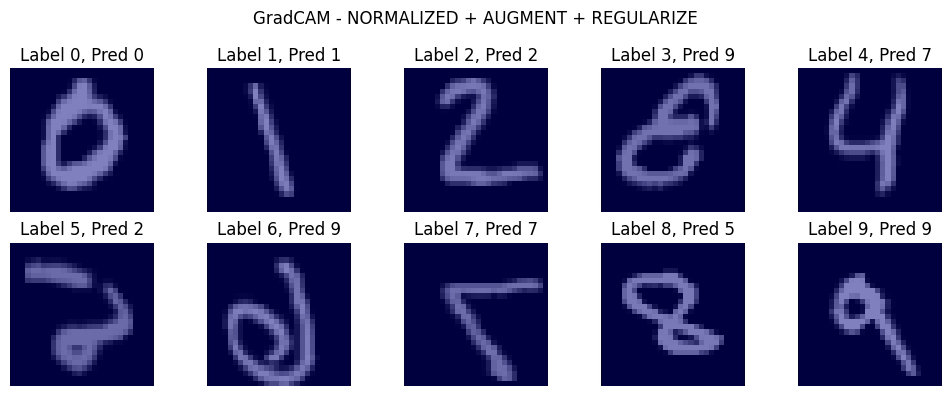


💾 Saving final results...


In [ ]:
# ---------------------------
# RUN EXPERIMENTS
# ---------------------------

results = []
histories = {}  

if os.path.exists("./feature_extraction_runs"):
    print("📂 Loading previous results...")
    with open("./feature_extraction_runs/results_featureextraction.pkl", "rb") as f:
        results, histories = pickle.load(f)
else:
    for variation_name, transform in transform_variations.items():
        print(f"\n🔹 Running {variation_name} dataset")

        dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size],
                                                  generator=torch.Generator().manual_seed(42))
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

        model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 256),
            nn.Dropout(0.2 if "Regularize" in variation_name else 0.0),
            nn.Linear(256, 128),
            nn.Dropout(0.2 if "Regularize" in variation_name else 0.0),
            nn.Linear(128, 64),
            nn.Dropout(0.2 if "Regularize" in variation_name else 0.0),
            nn.Linear(64, 32),
            nn.Dropout(0.2 if "Regularize" in variation_name else 0.0),
            nn.Linear(32, 10)
        )
        model = model.to(device)

        # ---- Train & Track ----
        history = {"train_loss": [], "train_acc": [], "val_acc": [],"val_loss": []}
        history = train_feature_extraction(
            model,
            train_loader,
            val_loader,
            epochs=10,
            lr=1e-4,
            regularize="Regularize" in variation_name,
            history=history
        )

        test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
        test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
        acc, prec, rec, f1 = evaluate(model, test_loader)
        print(f"✅ {variation_name} Test Accuracy: {acc:.2f}%")

        results.append({
            "Variation": variation_name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1
        })
        histories[variation_name] = history

        grad_cam = GradCAM(model, model.layer4[-1].conv2)
        fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
        axes_flat = axes.flatten()

        for i in range(10):
            ax = axes_flat[i]
            idx = np.where(np.array(test_dataset.targets) == i)[0][0]

            img, _ = test_dataset[idx]
            input_tensor = img.unsqueeze(0).to(device)
            input_tensor.requires_grad_()

            cam, cls = grad_cam.generate(input_tensor)

            # ✅ Convert to NumPy safely (handle both torch.Tensor and np.ndarray cases)
            if isinstance(cam, torch.Tensor):
                cam_np = cam.detach().cpu().squeeze().numpy()
            else:
                cam_np = np.array(cam).squeeze()  # convert scalar or list to np.ndarray

            # If it’s still 0D, expand it
            if cam_np.ndim == 0:
                cam_np = np.expand_dims(cam_np, axis=0)

            # Resize safely
            cam_resized = cv2.resize(cam_np.astype(np.float32), (img.shape[2], img.shape[1]))

            # ✅ Denormalize image
            img_dn = denormalize(img).squeeze().cpu()  # [1,H,W] or [3,H,W]

            # Handle grayscale or RGB correctly
            if img_dn.ndim == 2:
                ax.imshow(img_dn.numpy(), cmap="gray")
            else:
                ax.imshow(img_dn.permute(1, 2, 0).numpy())

            # Overlay GradCAM
            ax.imshow(cam_resized, cmap="jet", alpha=0.5)
            ax.set_title(f"Label {i}, Pred {cls}")
            ax.axis("off")

        plt.suptitle(f"GradCAM - {variation_name.upper()}")
        plt.tight_layout()
        plt.show()

    # --- Save data ----
    print("\n💾 Saving final results...")
    os.makedirs("./feature_extraction_runs", exist_ok=True)
    with open(f"./feature_extraction_runs/results_featureextraction.pkl", "wb") as f:
        pickle.dump((results, histories), f)


In [49]:
print(cam_np.dtype)

float32


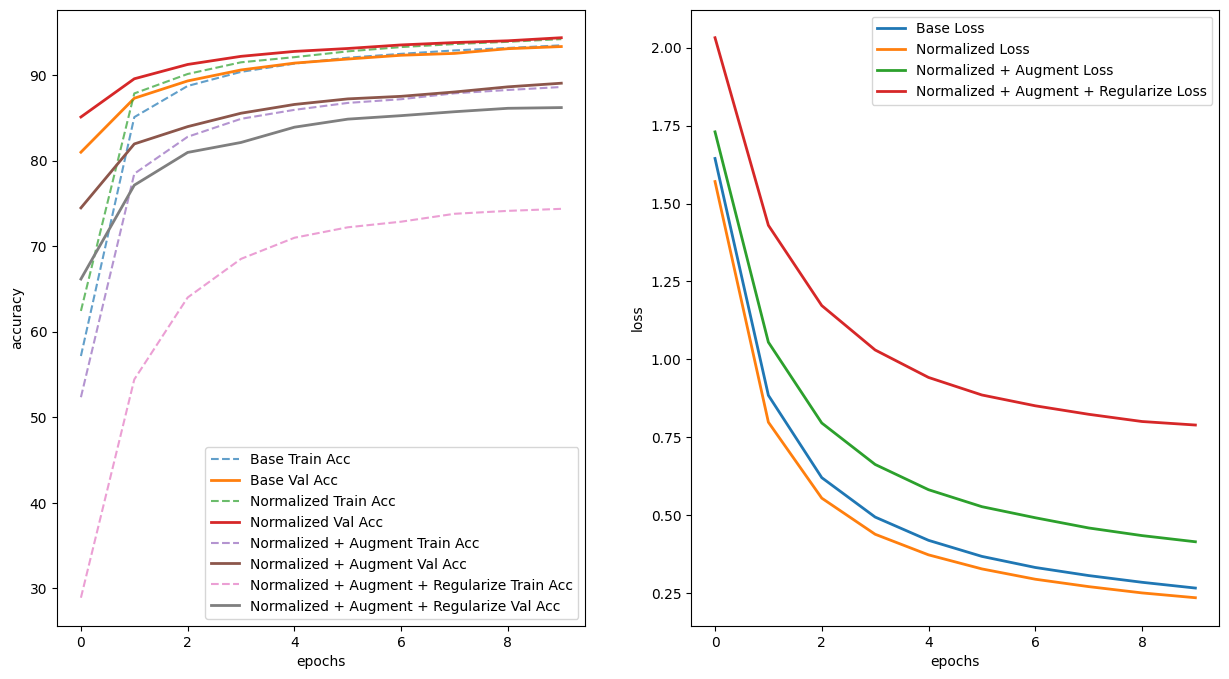

In [ ]:
# ---------------------------
# TRAINING PROGRESS CURVES (Loss + Accuracy)
# ---------------------------
plt.figure(figsize = (15, 8))
plt.subplot(1, 2, 1)
for variation_name, history in histories.items():
    plt.plot(history["train_acc"], linestyle="--", alpha=0.7, label=f"{variation_name} Train Acc")
    plt.plot(history["val_acc"], linewidth=2, label=f"{variation_name} Val Acc")
plt.xlabel ("epochs")
plt.ylabel ("accuracy")
plt.legend()

plt.subplot(1, 2, 2)
for variation_name, history in histories.items():
    plt.plot(history["train_loss"], linewidth=2, label=f"{variation_name} Loss")
plt.xlabel ("epochs")
plt.ylabel ("loss")
plt.legend()

plt.show()

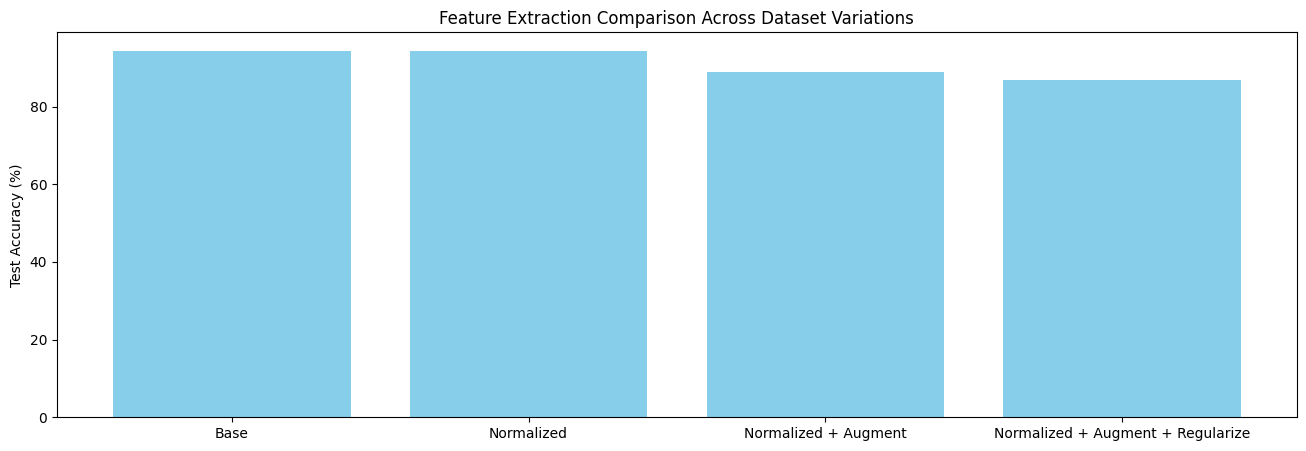

In [ ]:
# ---------------------------
# FINAL COMPARISON (BAR CHART)
# ---------------------------

plt.figure(figsize=(16,5))
names = [r["Variation"] for r in results]
values = [r["Accuracy"] for r in results]
plt.bar(names,values,  color='skyblue')
plt.ylabel("Test Accuracy (%)")
plt.title("Feature Extraction Comparison Across Dataset Variations")
plt.show()

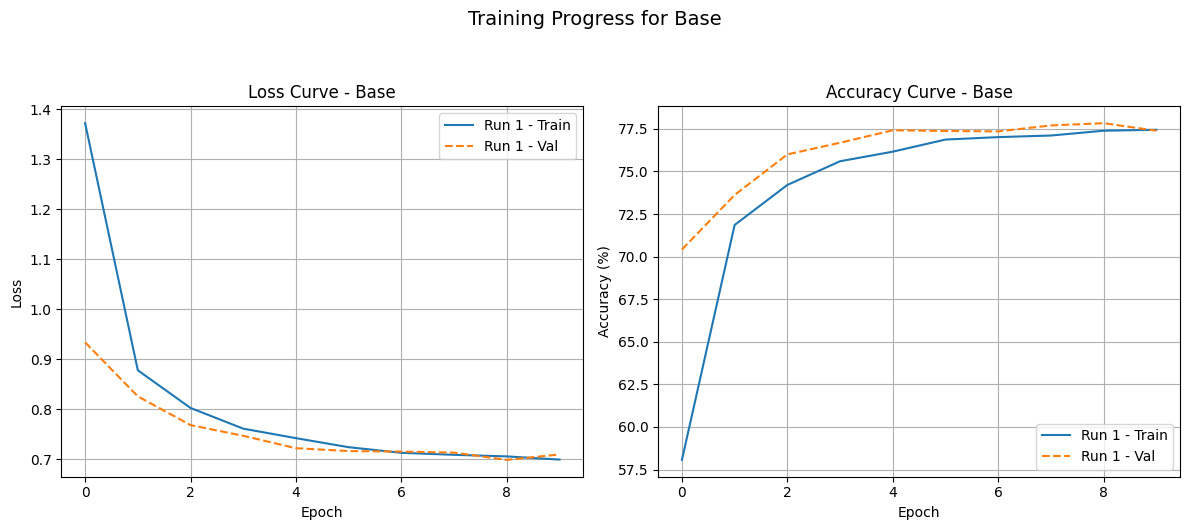

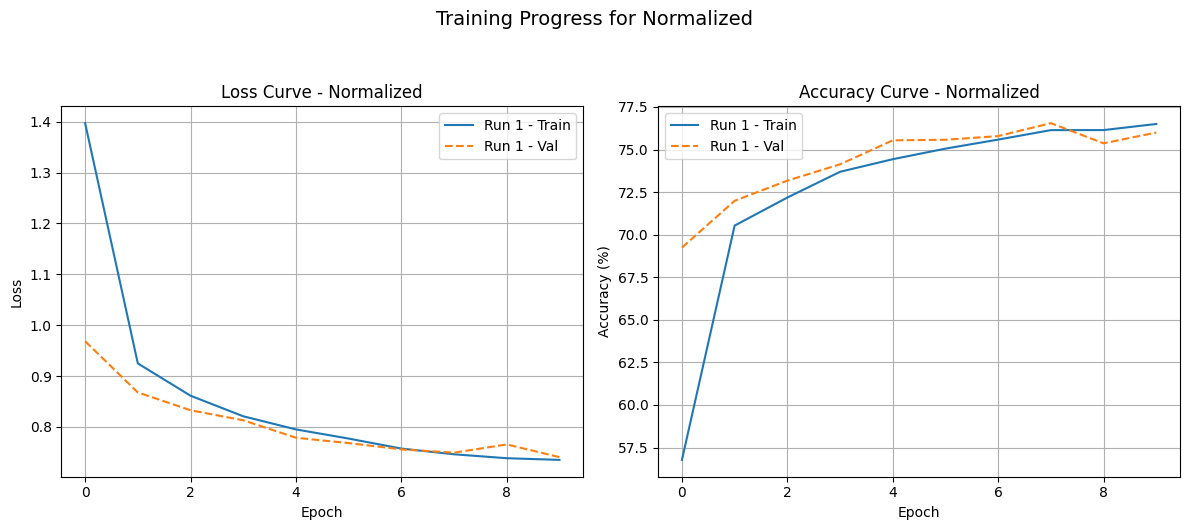

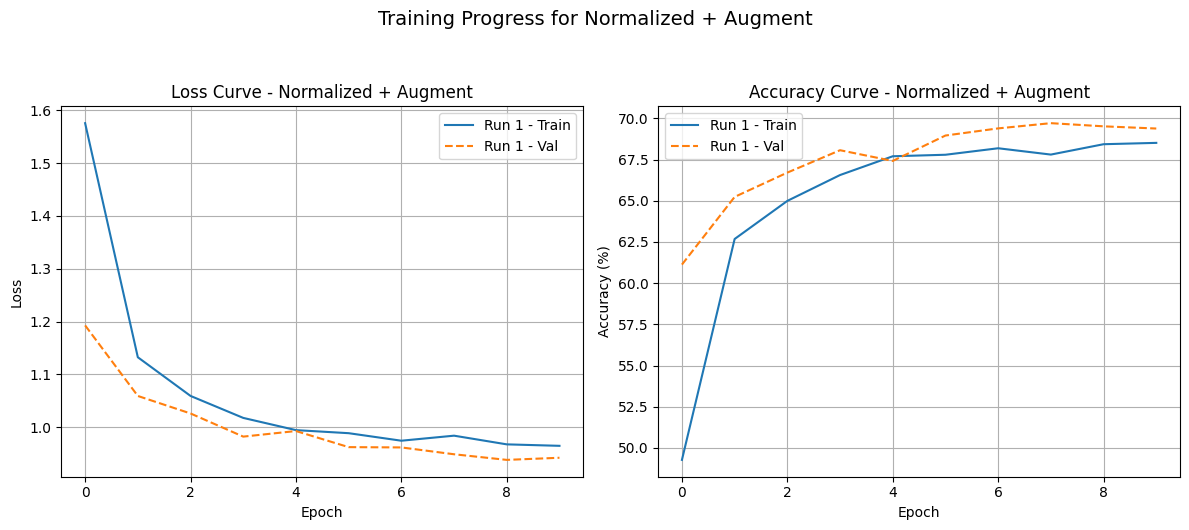

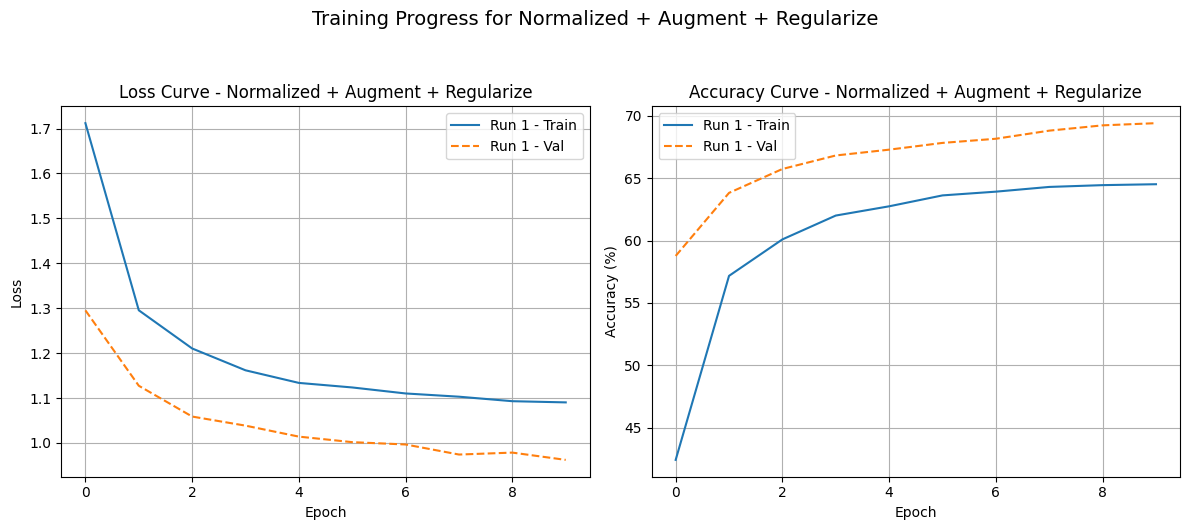

In [ ]:
# --- Load results ---
with open("./feature_extraction_runs/results_featureextraction.pkl", "rb") as f:
    summary, histories = pickle.load(f)

for key, val in histories.items():
    if isinstance(val, dict):
        histories[key] = [val] 

# --- Loop through each dataset variation ---
for variation, runs in histories.items():
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for i, run in enumerate(runs):
        plt.plot(run["train_loss"], label=f"Run {i+1} - Train")
        if "val_loss" in run:
            plt.plot(run["val_loss"], linestyle="--", label=f"Run {i+1} - Val")
    plt.title(f"Loss Curve - {variation}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    for i, run in enumerate(runs):
        if "train_acc" in run:
            plt.plot(run["train_acc"], label=f"Run {i+1} - Train")
        if "val_acc" in run:
            plt.plot(run["val_acc"], linestyle="--", label=f"Run {i+1} - Val")
    plt.title(f"Accuracy Curve - {variation}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)

    plt.suptitle(f"Training Progress for {variation}", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()